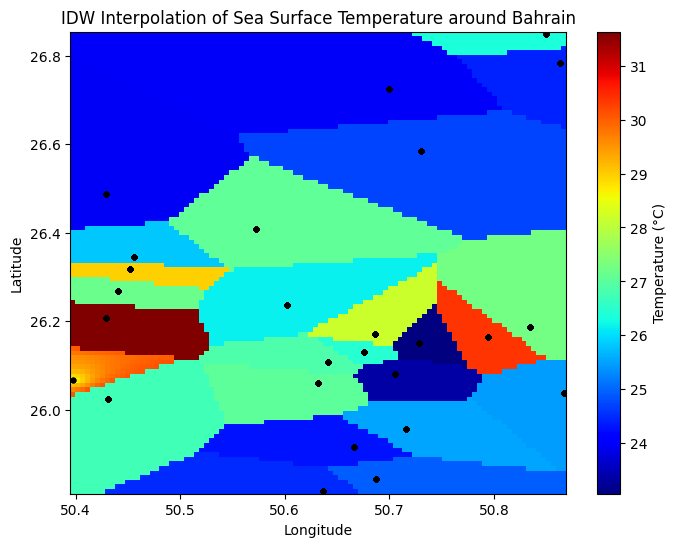

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

# Load the climate data
climate_data_path = 'marine 2007 - 2016 may 2017(1).csv'
climate_data = pd.read_csv(climate_data_path, encoding='ISO-8859-1')

# Load the geographic location data
geo_locations_path = 'Bahrain Climate Data - Geo Locations - Sheet2.csv'
geo_locations_data = pd.read_csv(geo_locations_path)

# Merge the climate data with the geo location data
data_merged = climate_data.merge(geo_locations_data, how='left', left_on='locations', right_on='Location')

# Correct the merge operation to use the right column names
# Assuming 'locations' is in the climate data and 'Location' is in the geo locations data
data_merged = climate_data.merge(geo_locations_data, how='left', left_on='locations', right_on='Location')

# Function to perform Inverse Distance Weighting (IDW) interpolation
def idw_interpolation(x, y, z, xi, yi, power=1):
    # Create a tree for fast spatial searching
    tree = cKDTree(np.vstack((x, y)).T)
    # Find the distances to the nearest neighbors and their indices
    distances, indices = tree.query(np.vstack((xi.ravel(), yi.ravel())).T, k=6)
    # Inverse distance weighting
    weights = 1 / distances**power
    # Handle infinities if we have zero distance
    weights[np.isinf(weights)] = 1.0
    # Calculate the interpolated values
    zi = np.sum(weights * z[indices], axis=1) / np.sum(weights, axis=1)
    zi = zi.reshape(xi.shape)
    return zi

# Clean the data
data_merged['Temperature oC'] = pd.to_numeric(data_merged['Temperature oC'], errors='coerce')
data_merged.dropna(subset=['Temperature oC', 'Longitude_dd', 'Latitude_dd'], inplace=True)

# Get the coordinates and values, ensuring they are finite
x = data_merged['Longitude_dd'].values
y = data_merged['Latitude_dd'].values
z = data_merged['Temperature oC'].values  # Replace 'Temperature oC' with the correct column name from your climate data

# Define the grid over which to interpolate
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Perform IDW interpolation
zi = idw_interpolation(x, y, z, xi, yi)

# Plotting the interpolated data
plt.figure(figsize=(8, 6))
plt.pcolormesh(xi, yi, zi, shading='auto', cmap='jet')
plt.colorbar(label='Temperature (°C)')
plt.scatter(x, y, c='black', s=10)  # Plot the location of the original data points
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('IDW Interpolation of Sea Surface Temperature around Bahrain')
plt.show()